In [415]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashutosh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Natural Language Toolkit (NLTK), a powerful library widely used in natural language processing (NLP).

A TSV file is used, which is large.

In [416]:
data = pd.read_csv("amazon_alexa.tsv", delimiter='\t', quoting=3)
data.shape

(3150, 5)

In [417]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [418]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [419]:
data[data["verified_reviews"].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [420]:
data.dropna(inplace=True)

In [421]:
data.shape

(3149, 5)

In [422]:
data['length'] = data['verified_reviews'].apply(len)

In [423]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [424]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [425]:
data["rating"].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

In [426]:
2286*100/3149

72.594474436329

In [427]:
455*100/3149

14.449031438551922

Text(0, 0.5, 'Count')

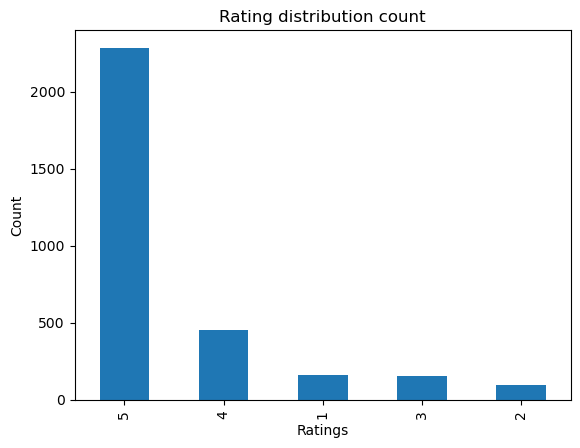

In [428]:
data['rating'].value_counts().plot.bar()
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')

In [429]:
round(data['rating'].value_counts()/data.shape[0]*100, 2)

rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64

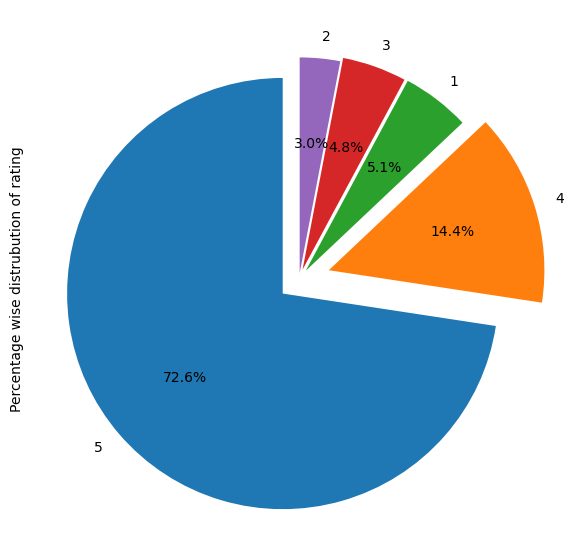

In [430]:
fig = plt.figure(figsize=(7,7))
# colors = ('red', 'green', 'blue','orange','yellow')
# wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

# explode=(0.1,0.1,0.1,0.1,0.1)

explode = pd.concat([pd.Series([0.1]), tags.iloc[1:]])

tags.plot(kind='pie', autopct="%1.1f%%", shadow=False,
           startangle=90 , explode=explode, label='Percentage wise distrubution of rating')
from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

In [431]:
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

In [432]:
# review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
data[data['feedback'] == 0].iloc[1]['verified_reviews']

'Sound is terrible if u want good music too get a bose'

In [433]:
data[data['feedback'] == 1].iloc[1]['verified_reviews']

'Loved it!'

In [434]:
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [435]:
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

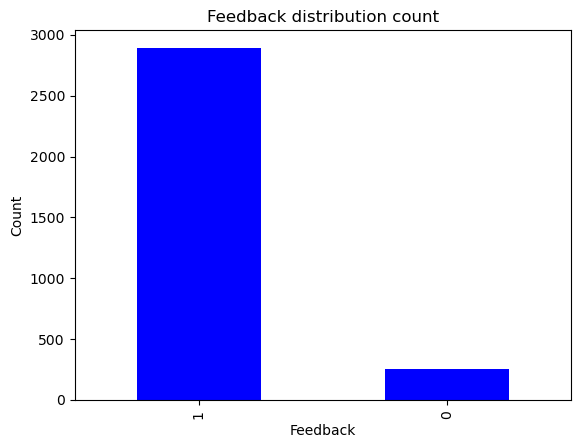

In [436]:
data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [437]:
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

In [438]:
data.shape[0]

3149

<Axes: ylabel='Percentage wise feedback distrubution'>

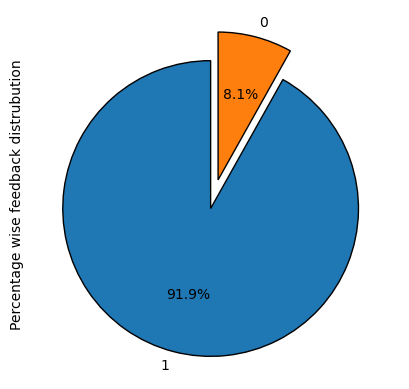

In [439]:
(data['feedback'].value_counts()/data.shape[0]).plot(kind='pie', autopct="%1.1f%%", shadow=False, explode=(0.1, 0.1),
           startangle=90 , label='Percentage wise feedback distrubution', wedgeprops={'linewidth':1, "edgecolor":'black'})

In [440]:
data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

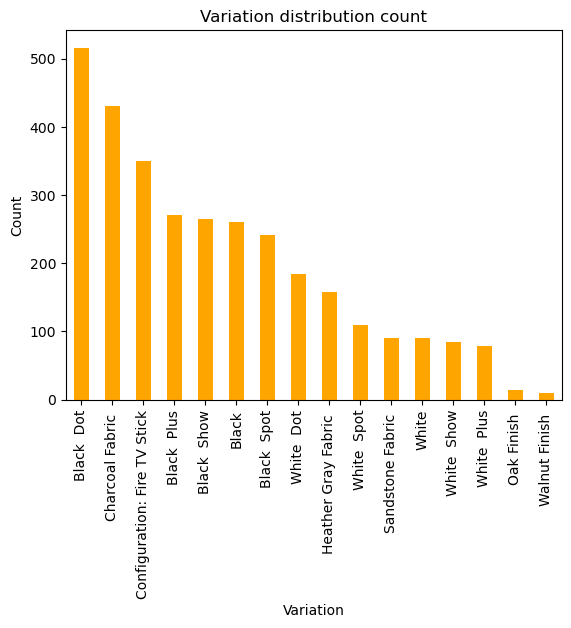

In [441]:
data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [442]:
round(data['variation'].value_counts()/data.shape[0]*100,2)

variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64

In [443]:
data.groupby('variation').first()

,rating,date,verified_reviews,feedback,length
variation,,,,,
Black,1,31-Jul-18,Item no longer works after just 5 months of us...,0,109
Black Dot,5,31-Jul-18,"""I set her up to play through our home theater...",1,154
Black Plus,4,31-Jul-18,We use Alexa primarily for listening to music ...,1,205
Black Show,5,31-Jul-18,I love love love love it! I feel like I have ...,1,90
Black Spot,5,31-Jul-18,I used the product for my phone to look up the...,1,71
Charcoal Fabric,5,31-Jul-18,Love my Echo!,1,13
Configuration: Fire TV Stick,5,31-Jul-18,Ideal when you have Amazon Prime.. My very fir...,1,210
Heather Gray Fabric,5,31-Jul-18,"""I received the echo as a gift. I needed anoth...",1,174
Oak Finish,5,30-Jul-18,"""I purchased this for my mother who is having ...",1,292


In [444]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

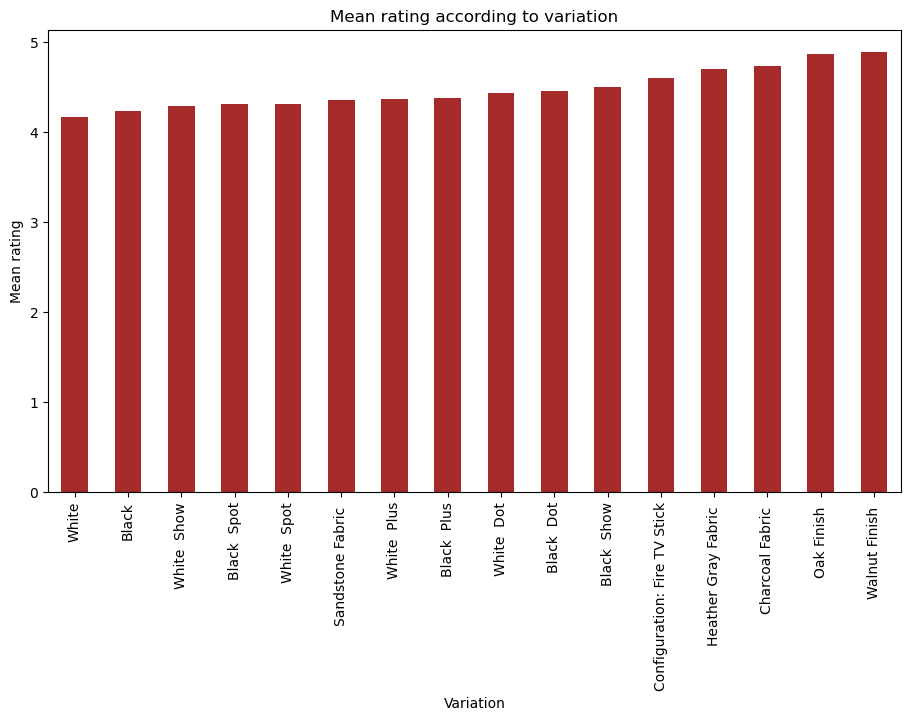

In [445]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

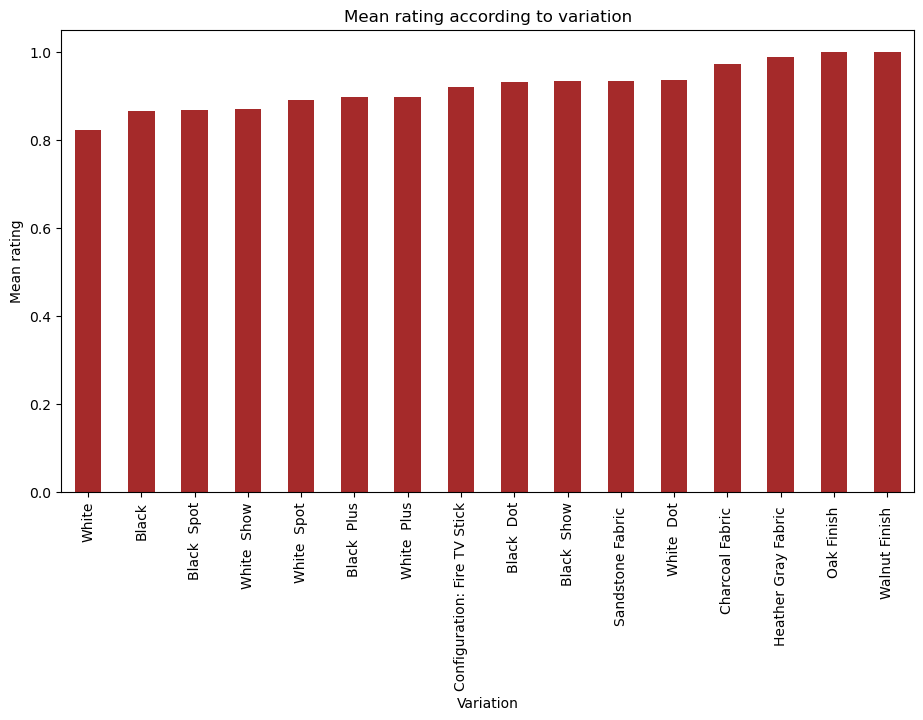

In [446]:
data.groupby('variation')['feedback'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

In [447]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of review ')]

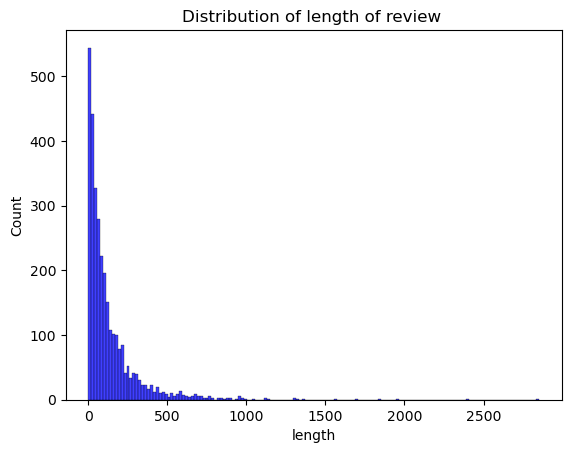

In [448]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

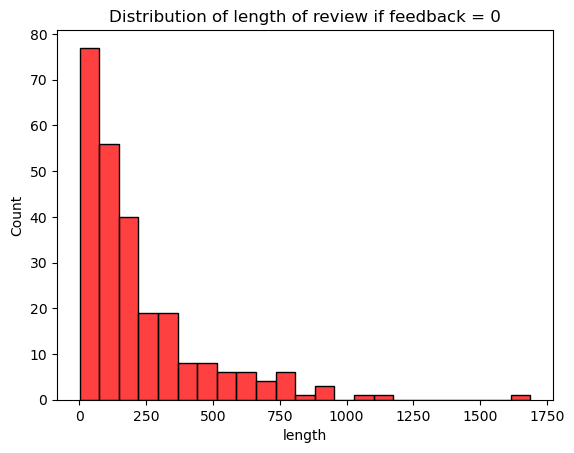

In [449]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

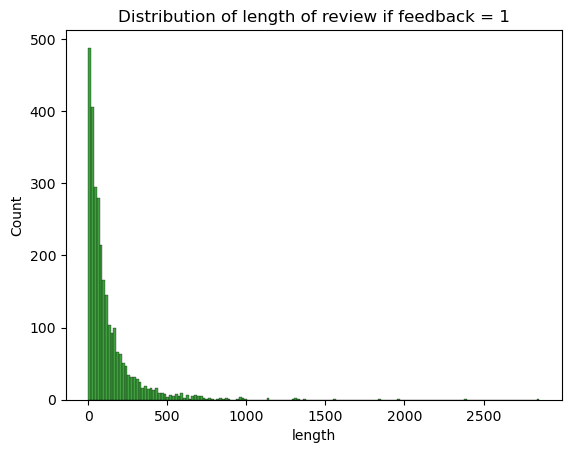

In [450]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

In [451]:
data.groupby('length')['rating'].count()

length
1       81
2        4
3        3
4       14
5       17
        ..
1688     1
1835     1
1956     1
2395     1
2853     1
Name: rating, Length: 495, dtype: int64

In [452]:
data.groupby('length')['rating'].mean()

length
1       3.716049
2       5.000000
3       4.000000
4       4.785714
5       4.823529
          ...   
1688    2.000000
1835    3.000000
1956    3.000000
2395    5.000000
2853    5.000000
Name: rating, Length: 495, dtype: float64

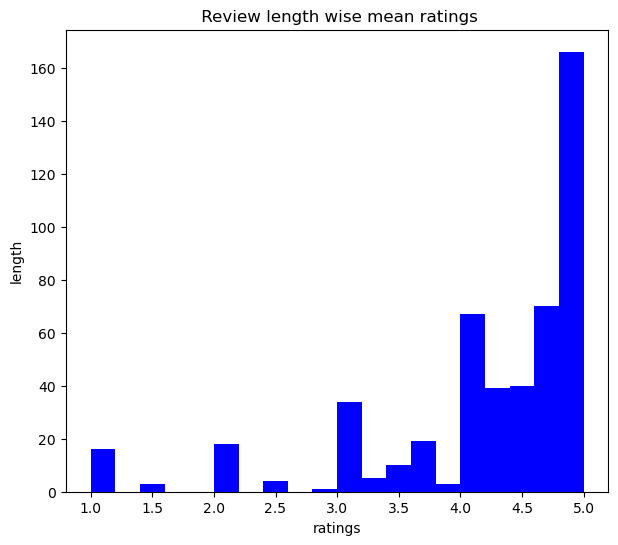

In [453]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [454]:
data1 = pd.read_csv("l&t_review_and_rating_ambitionbox_cleaned.csv")
data1.shape

(9990, 3)

In [455]:
data1.head()

,review,rating,sentiment
0,would say people must work l know could worse ...,2.0,negative
1,1 overall good company work 2 timely payment s...,4.0,positive
2,worked l found top management always support s...,5.0,positive
3,good learning freedom work job security develo...,4.0,positive
4,company culture good payroll employee m1a cadr...,3.0,negative


In [456]:
def rating2feedback(string):
    if string == 'negative':
        return 0
    else :
        return 1


data1['feedback']=data1['sentiment'].apply(lambda x: rating2feedback(x))

In [457]:
data1.head()

,review,rating,sentiment,feedback
0,would say people must work l know could worse ...,2.0,negative,0
1,1 overall good company work 2 timely payment s...,4.0,positive,1
2,worked l found top management always support s...,5.0,positive,1
3,good learning freedom work job security develo...,4.0,positive,1
4,company culture good payroll employee m1a cadr...,3.0,negative,0


In [458]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [459]:
def rating2Feedback(num):
    if num>3:
        return 1
    else :
        return 0


data['feedback']=data['rating'].apply(lambda x: rating2Feedback(x))

In [460]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [461]:
data1.rename(columns={'review': 'verified_reviews'}, inplace=True)

In [462]:
data1.head(1)

,verified_reviews,rating,sentiment,feedback
0,would say people must work l know could worse ...,2.0,negative,0


In [463]:
data = data.filter(items=['verified_reviews', 'feedback'])
data1 = data1.filter(items=['verified_reviews', 'feedback'])

data.head(), data1.head()

(                                    verified_reviews  feedback
 0                                      Love my Echo!         1
 1                                          Loved it!         1
 2  "Sometimes while playing a game, you can answe...         1
 3  "I have had a lot of fun with this thing. My 4...         1
 4                                              Music         1,
                                     verified_reviews  feedback
 0  would say people must work l know could worse ...         0
 1  1 overall good company work 2 timely payment s...         1
 2  worked l found top management always support s...         1
 3  good learning freedom work job security develo...         1
 4  company culture good payroll employee m1a cadr...         0)

In [464]:
data.shape, data1.shape

((3149, 2), (9990, 2))

In [465]:
data = pd.concat([data, data1], ignore_index=True)
data.shape

(13139, 2)

In [466]:
data.isna().sum()

verified_reviews    10
feedback             0
dtype: int64

In [467]:
data.dropna(inplace=True)

In [468]:
data.isna().sum()

verified_reviews    0
feedback            0
dtype: int64

In [469]:
data['feedback'].value_counts()

feedback
1    10124
0     3005
Name: count, dtype: int64

<Axes: ylabel='Percentage wise feedback distrubution'>

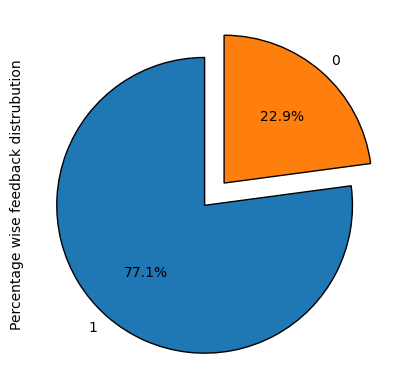

In [470]:
(data['feedback'].value_counts()/data.shape[0]).plot(kind='pie', autopct="%1.1f%%", shadow=False, explode=(0.1, 0.1),
           startangle=90 , label='Percentage wise feedback distrubution', wedgeprops={'linewidth':1, "edgecolor":'black'})

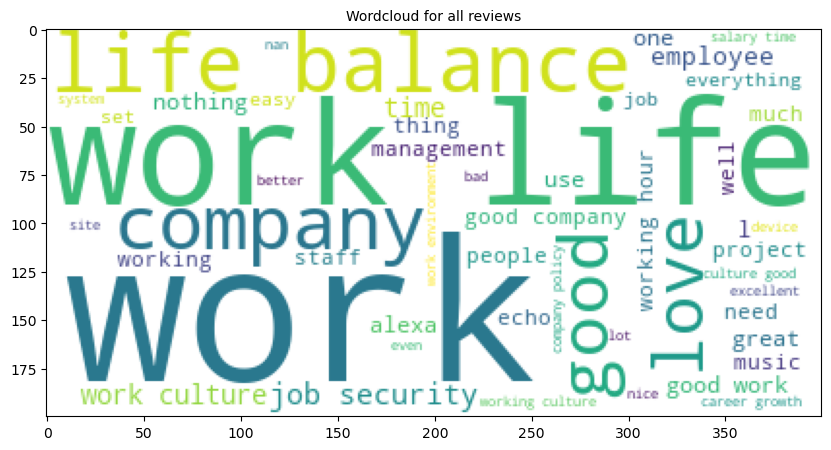

In [471]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']]).lower()
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
# plt.axis('off')
plt.show()

In [472]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()
neg_reviews_set = set(neg_reviews)

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()
pos_reviews_set = set(pos_reviews)

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews_set]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews_set]
unique_positive = " ".join(unique_positive)

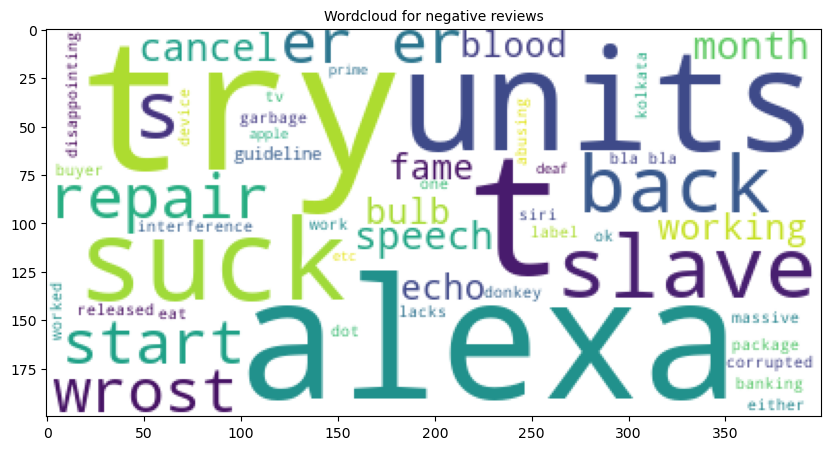

In [473]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
# plt.axis('off')
plt.show()

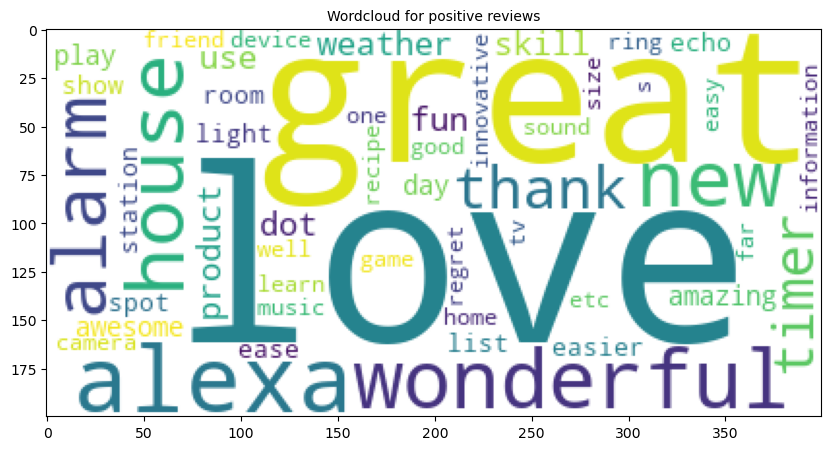

In [474]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
# plt.axis('off')
plt.show()

This code processes each review in the `verified_reviews` column of the `data` DataFrame by removing non-letter characters, converting to lowercase, splitting into words, stemming each word, and excluding stopwords. The processed reviews are then joined back into strings and stored in a list called `corpus`.

stemming means reduce words to their base or root form. For example, the words "running," "runner," and "ran" are all stemmed to the root word "run."

In [475]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

This code creates a `CountVectorizer` to convert text into a matrix of token counts, limited to the top 2500 most frequent words. It then transforms the processed text data in `corpus` into a numerical array (`X`) and stores the 'feedback' column of the `data` DataFrame as the target variable (`y`).

In [476]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [477]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (13129, 2500)
y shape: (13129,)


This code uses `StratifiedShuffleSplit` to split data into training and testing sets while maintaining the same class distribution in both sets. It then prints the shapes of the resulting datasets and checks the class distribution to ensure balance.

In [478]:
from sklearn.model_selection import StratifiedShuffleSplit

# Perform stratified split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=15)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Print shapes of the resulting datasets
print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

# Check the distribution of classes in training and testing data
print("Class distribution in y_train:", np.bincount(y_train))
print("Class distribution in y_test:", np.bincount(y_test))

X train: (10503, 2500)
y train: (10503,)
X test: (2626, 2500)
y test: (2626,)
Class distribution in y_train: [2404 8099]
Class distribution in y_test: [ 601 2025]


The `sss.split(X, y)` returns two sets of indices: one for training data and one for testing data. These indices specify which rows from `X` and `y` should go into the training set and which should go into the testing set, keeping the class proportions balanced.

In [479]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

# print(f"X train: {X_train.shape}")
# print(f"y train: {y_train.shape}")
# print(f"X test: {X_test.shape}")
# print(f"y test: {y_test.shape}")

This code prints the maximum value found in the `X_train` and `X_test` datasets. It helps to understand the range of values in the training and testing data.

In [480]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 14


This code initializes a `MinMaxScaler` to normalize the features by scaling them to a range between 0 and 1. It then fits the scaler to the `X_train` data and transforms both `X_train` and `X_test` to have values within this range.

In [481]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

### Random Forest

This code initializes a `RandomForestClassifier` and trains (fits) it using the scaled training data (`X_train_scl`) and the corresponding target values (`y_train`). This prepares the model to make predictions based on the training data.

In [482]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

This code prints the accuracy of the Random Forest model on both the training and testing datasets. It shows that the model performs very well on the training data (98% accuracy) but less well on the testing data (about 81% accuracy), indicating potential overfitting.

In [483]:
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9801961344377796
Testing Accuracy : 0.8088347296268088


This code uses the trained Random Forest model to predict the target values (y_preds) for the test dataset (X_test_scl). 

In [484]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

This code computes the confusion matrix, which is a table used to evaluate the performance of the Random Forest model. The matrix compares the actual target values (`y_test`) with the predicted values (`y_preds`) to show the counts of true positives, true negatives, false positives, and false negatives.

In [485]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

This code displays a confusion matrix plot, showing how well the model's predictions match the actual values. It helps to visualize the counts of correct and incorrect predictions for each class.

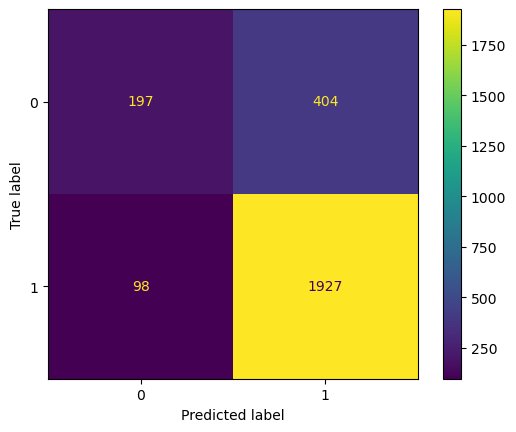

In [486]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

### K fold cross-validation

This code performs 10-fold cross-validation on the training data using the Random Forest model, calculating accuracy for each fold. It then prints the average accuracy and the standard deviation of the accuracies, providing a measure of the model's performance and consistency.

In [487]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 5)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.8048183404727907
Standard Variance : 0.007712604427386242


### Applying grid search to get the optimal parameters on random forest

This code finds the best settings for a Random Forest model by testing different combinations of parameters. It uses cross-validation to check each combination's performance and picks the best one. Finally, it prints the best parameters and the average accuracy on both training and testing sets.

In [409]:
params = {
    'bootstrap': [True],
    'max_depth': [200, 300, 400],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300, 500]
}

In [410]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [200, 300, 400],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300, 500]},
             return_train_score=True)

In [411]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 400, 'min_samples_split': 8, 'n_estimators': 100}


In [412]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 94.3534665568281
Cross validation mean accuracy on test set : 80.13001805029396
Accuracy score for test set : 0.8088347296268088


### XgBoost

The `XGBoost` classifier is set up and trained with the training data.
The code checks how well the model performs on both training and testing data by calculating the accuracy.

In [488]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [489]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.8531848043416167
Testing Accuracy : 0.8084539223153084


- Calculate Confusion Matrix: Compare the actual test values with the predicted values to count true positives, true negatives, false positives, and false negatives.
- Print and Plot: Show the confusion matrix as text and a visual plot to easily interpret the model's performance.

In [490]:
y_preds = model_xgb.predict(X_test)

In [491]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 202  399]
 [ 123 1902]]


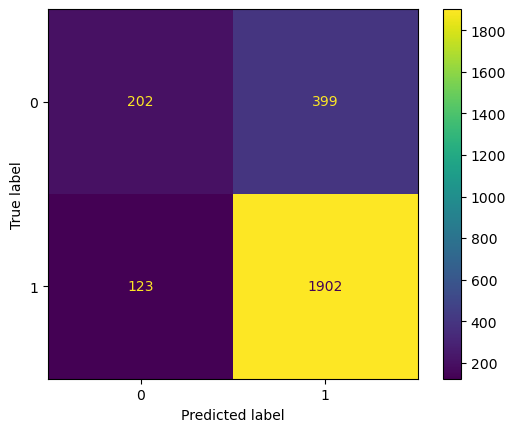

In [492]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

### Decision Tree Classifier

In [493]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [494]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9802913453299057
Testing Accuracy : 0.746001523229246


In [495]:
y_preds = model_dt.predict(X_test)

In [496]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 293  308]
 [ 588 1437]]


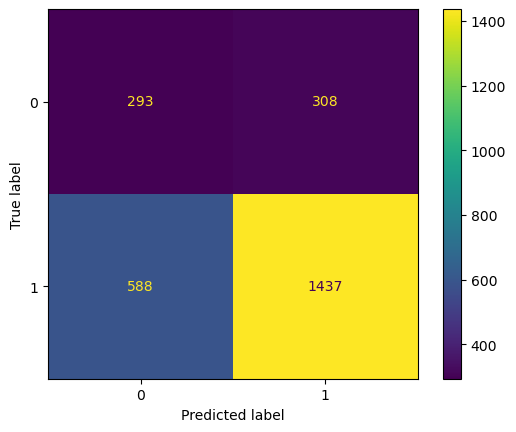

In [497]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

The dicision tree gives 91% while random forest gives 92-93% accuracy, data distribution is 92% positive reviews and 8% negative reviews. Hence, we don't use these both models, instead we use xg boost model.

### Neaural Network

- Build Model: Creates a neural network with three layers to process input data of 2500 features.
- Compile Model: Prepares the model for training using the Adam optimizer and binary cross-entropy loss.
- Early Stopping: Stops training early if the validation loss doesn't improve for 5 epochs, restoring the best weights.
- Train and Evaluate: Trains the model with early stopping, then evaluates its performance on test data.

In [536]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [537]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(2500,)),
  tf.keras.layers.Dense(1224, activation=tf.nn.relu),
  tf.keras.layers.Dense(612, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [538]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [539]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [540]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train_scl, y_train, 
                    epochs=500, 
                    validation_split=0.1, 
                    callbacks=[early_stopping], verbose=0) 

In [529]:
l=len(history.history['loss'])
l

6

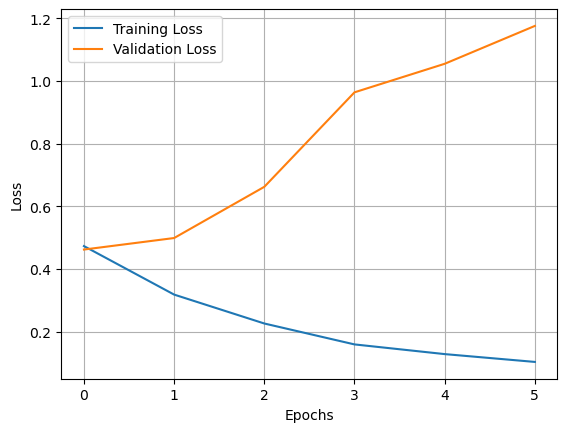

In [530]:
# Plot learning curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(ticks=np.arange(0, l, 1), labels=[f'{i}' for i in range(l)])
plt.legend()
plt.grid()
plt.show()

In [522]:
model.evaluate(X_test_scl, y_test)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8057 - loss: 0.4242


[0.42904627323150635, 0.8035034537315369]

In [523]:
classifications = model.predict(X_test)
print(classifications[0])
print(y_test[0])

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[0.2566522]
1
